# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>



 

## Сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [ ]:
# pip install pymystem3

In [ ]:
# pip install string

In [ ]:
# !pip install -q tensorflow==2.3

In [ ]:
#аугментации изображений
!pip install albumentations -q

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

from datetime import datetime, date, time
now = datetime.now()
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [8]:

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [9]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [10]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
INITIAL_DATA = '../input/formodel/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')
# df= pd.read_csv(INITIAL_DATA +'for_model_DL.csv')

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [11]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [12]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())
    

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Посмотрим, как выглядят распределения числовых признаков:

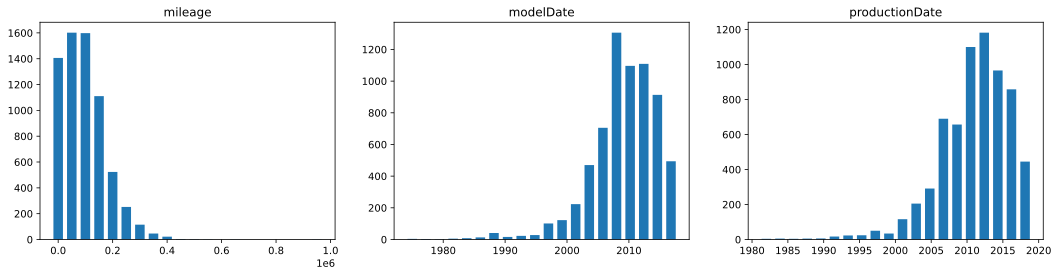

In [13]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()    
})

Итого:
* Распределение признаков не нормальное. Далее по листингу нормируем числовые признаки и создадим новые. Так же выделим категориальные, числовые и бинарные признаки 

# PreProc Tabular Data

In [14]:

train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [15]:
data['status'] = 0

#### Из признака 'mileage' выделим новый признак 'status', который будет указывать на пробег автомобиля по обобщенным категориям.

In [16]:
def stat(data):
    df = data.copy()
    
    for i in df.index:
        if df['mileage'][i] <= 100:
            df['status'][i] = 1
        elif (df['mileage'][i] > 100)&(df['mileage'][i]<=5000):
            df['status'][i] = 2
        elif (df['mileage'][i] > 5000)&(df['mileage'][i]<=20000):
            df['status'][i] = 3
        elif (df['mileage'][i] > 20000)&(df['mileage'][i]<=70000):
            df['status'][i] = 4
        elif (df['mileage'][i] > 70000)&(df['mileage'][i]<=100000):
            df['status'][i] = 5
        elif (df['mileage'][i] > 100000)&(df['mileage'][i]<=200000):
            df['status'][i] = 6
        elif (df['mileage'][i] > 200000)&(df['mileage'][i]<=300000):
            df['status'][i] = 7
        elif (df['mileage'][i] > 300000)&(df['mileage'][i]<=500000):
            df['status'][i] = 8
        elif (df['mileage'][i] > 500000):
            df['status'][i] = 9
    return df

In [ ]:
data = stat(data)

#### Имея понимание о признаках и принимаемых ими значениях разделим всё на три категории

In [18]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'name',
  'vehicleTransmission', 'ПТС', 'Привод', 'Руль','status']

#используем все числовые признаки
numerical_features = ['modelDate', 'Владельцы', 'productionDate','mileage', 'enginePower', 'engineDisplacement']

# бинарный признаки

binary_features = ['popular_color','rare_color','very_rare_color','ПТС']

### Обработка данных

In [19]:
data.head(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,status
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,...,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0,8
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,...,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0,3


#### Создадим функцию, которая будет выполнять работу по преобразованию признаков, нормализацию и удаление лишней инфорации

In [20]:
def preproc_data(df_input):
    
    df_output = df_input.copy()
    
    # #1. Предобработка 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
    df_output.drop(['Владение'], axis = 1, inplace=True) #много пропусков, поэтому удаляем

#     Преобразуем признак даты выпуска в целочисленное значение и переведем в месяцы 
    df_output['productionDate'] = np.log(df_output['productionDate'].apply(lambda x: (int(now.year) - int(x))*12))
    
#     Длительность выпуска еонкретной модели переведем в целочисленное значение
    df_output['modelDate'] = df_output['modelDate'].apply(lambda x: int(x))
    df_output['modelDate'] = pd.to_datetime(df_output['modelDate'], format = '%Y')
    df_output['model_age'] = (now - df_output['modelDate'])
    df_output['model_age'] = np.log(df_output['model_age'].apply(lambda x: int(int(str(x).split(' ')[0])/30)))
    df_output = df_output.drop(['modelDate'],axis = 1)
    df_output = df_output.rename({'model_age':'modelDate'}, axis='columns')
    

    
#     Прологорифмируем значение, чтоб нормализовать
    df_output['mileage'] = np.log(df_output['mileage'])
    

#     Создадим словарь со значениями признака Владельцы, чтоб далее заменить
    owners_dict = {
    '1\xa0владелец': 1,
    '2\xa0владельца': 2,
    '3 или более': 3
    }
    df_output['Владельцы'] = df_output['Владельцы'].map(owners_dict)
    
#     Мощность двигателся приведем к целочисленным значениям
    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: int(x.split(' ')[0]))
    
#     Выделим из признака значение объёма двигателя
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(lambda x: '2.0 LTR' if x == 'undefined LTR' else x)
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(lambda x: (x.split(' ')[0].replace('.', '')))
    df_output['engineDisplacement'] = df_output['engineDisplacement'].astype('int')
    df_output['engineDisplacement'].value_counts()
    
#     Информацию о модели выделим и приведём к обобщенным формам
    df_output.loc[df_output['model_info'] == '100', 'model_info'] = 'S4'
    df_output.loc[df_output['model_info'] == 'COUPE', 'model_info'] = 'S2'
    df_output.loc[df_output['model_info'] == 'None', 'model_info'] = 'C_KLASSE_AMG'
    # ################### Feature Engineering ####################################################
    
#     Разнообразие цветов обобщим в категориях
    for i in df_output.index:
        if 'xDrive' in df_output.name[i]:
            df_output['name'][i] = 'xDrive'
        else:
            df_output['name'][i] = '0'
    
    popular_colors = [
    'чёрный', 
    'белый', 
    'серый', 
    'синий'
    ]

    rare_colors = [
    'серебристый',
    'коричневый',
    'красный'
    ]

    df_output['popular_color'] = 0
    df_output['rare_color'] = 0
    df_output['very_rare_color'] = 0
    
    counter = 0

    for color in data['color']:
        if color in popular_colors:
            df_output.at[counter,'popular_color'] = 1
            counter += 1
        elif color in rare_colors:
            df_output.at[counter,'rare_color'] = 1
            counter += 1
        else:
            df_output.at[counter,'very_rare_color'] = 1
            counter += 1
    
    
    # ################### Numerical Features ############################################################## 
    
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
       
   
   
    
    # ################### Clean #################################################### 
    
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)

    df_output.drop(['numberOfDoors'], axis = 1, inplace=True)
    
    return df_output

In [21]:
data.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'sample', 'price', 'status'],
      dtype='object')

In [22]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,engineDisplacement,enginePower,mileage,productionDate,Владельцы,sample,price,modelDate,popular_color,rare_color,...,Руль_1,status_0,status_1,status_2,status_3,status_4,status_5,status_6,status_7,status_8
7399,0.220339,0.2720,0.838231,0.489076,0.0,1,1590000.0,0.374914,0,1,...,0,0,0,0,0,0,1,0,0,0
4273,0.220339,0.2720,0.775535,0.439310,0.0,1,3100000.0,0.415920,1,0,...,0,0,0,0,1,0,0,0,0,0
3362,0.813559,0.8160,0.790060,0.489076,1.0,1,3750000.0,0.415920,1,0,...,0,0,0,0,1,0,0,0,0,0
2794,0.389831,0.2720,0.849485,0.628510,1.0,1,1990000.0,0.485037,1,0,...,0,0,0,0,0,0,1,0,0,0
5378,0.220339,0.2288,0.862198,0.489076,1.0,1,1285000.0,0.415920,1,0,...,0,0,0,0,0,0,1,0,0,0
5902,0.559322,0.7760,0.807309,0.567601,0.0,1,3399999.0,0.452317,0,0,...,0,0,0,0,1,0,0,0,0,0
1454,0.389831,0.3920,0.787059,0.489076,0.5,0,0.0,0.452317,1,0,...,0,0,0,0,1,0,0,0,0,0
2476,0.305085,0.2288,0.873217,0.700125,1.0,1,700000.0,0.592263,1,0,...,0,0,0,0,0,0,1,0,0,0
743,0.152542,0.0640,0.846530,0.654526,1.0,0,0.0,0.592263,1,0,...,0,0,0,0,0,0,1,0,0,0
1168,0.813559,0.7504,0.759384,0.531153,1.0,0,0.0,0.452317,1,0,...,0,0,0,0,1,0,0,0,0,0


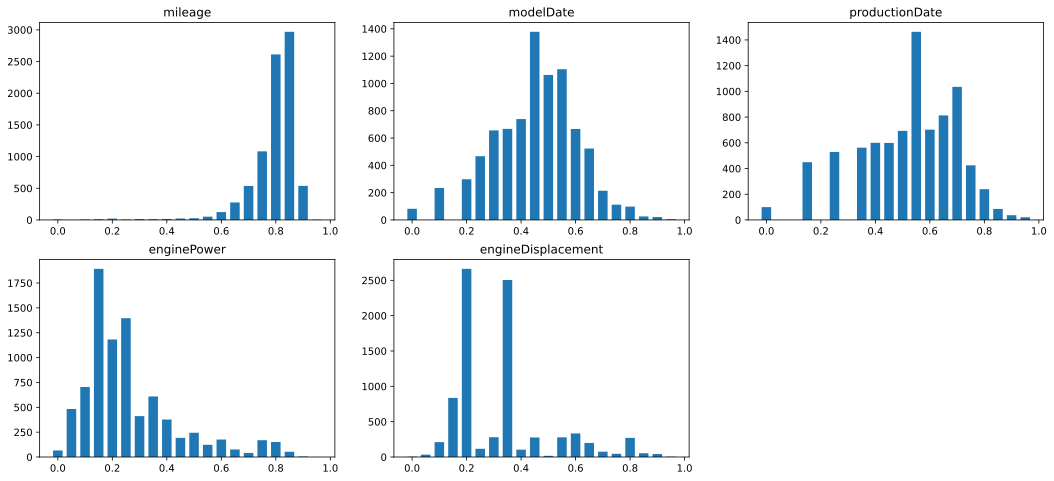

In [23]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': df_preproc['mileage'],
    'modelDate': df_preproc['modelDate'],
    'productionDate': df_preproc['productionDate'],
    'enginePower':df_preproc['enginePower'],
    'engineDisplacement':df_preproc['engineDisplacement'],
#     'mil_per_year':df_preproc['mil_per_year']
})

In [24]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 193 entries, engineDisplacement to status_8
dtypes: float64(7), int64(4), uint8(182)
memory usage: 2.2 MB


In [25]:
df_preproc.columns

Index(['engineDisplacement', 'enginePower', 'mileage', 'productionDate',
       'Владельцы', 'sample', 'price', 'modelDate', 'popular_color',
       'rare_color',
       ...
       'Руль_1', 'status_0', 'status_1', 'status_2', 'status_3', 'status_4',
       'status_5', 'status_6', 'status_7', 'status_8'],
      dtype='object', length=193)

In [26]:
df_preproc.head(2)

,engineDisplacement,enginePower,mileage,productionDate,Владельцы,sample,price,modelDate,popular_color,rare_color,...,Руль_1,status_0,status_1,status_2,status_3,status_4,status_5,status_6,status_7,status_8
0,0.389831,0.2320,0.924011,0.928385,1.0,0,0.0,0.903183,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0.389831,0.3808,0.696015,0.567601,0.0,0,0.0,0.485037,1,0,...,0,0,0,1,0,0,0,0,0,0


In [27]:
df_preproc[numerical_features].corr(method = 'pearson')

,modelDate,Владельцы,productionDate,mileage,enginePower,engineDisplacement
modelDate,1.000000,0.528994,0.937866,0.635851,-0.104301,0.181405
Владельцы,0.528994,1.000000,0.562621,0.424213,-0.012353,0.121302
productionDate,0.937866,0.562621,1.000000,0.721958,-0.082074,0.186645
mileage,0.635851,0.424213,0.721958,1.000000,-0.170577,0.011948
enginePower,-0.104301,-0.012353,-0.082074,-0.170577,1.000000,0.860391
engineDisplacement,0.181405,0.121302,0.186645,0.011948,0.860391,1.000000


## Split data

In [28]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [29]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 192 entries, engineDisplacement to status_8
dtypes: float64(7), int64(3), uint8(182)
memory usage: 440.6 KB


### Посмотрим значимость признаков

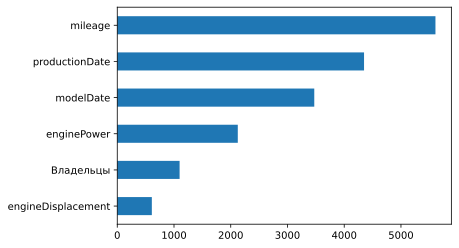

In [30]:
from sklearn.feature_selection import f_regression, mutual_info_regression
nums = pd.Series(f_regression(train_data[numerical_features], train_data['price'])[0], index = numerical_features)
nums.sort_values(inplace = True)
nums.plot(kind = 'barh')

# Model 2: CatBoostRegressor

#### Grid Search указал наилучшими параметры для модели CatBoost комбинацию из следующих параметров: depth=10, learning_rate = 0.01, l2_leaf_reg = 3. 

In [31]:
cat = CatBoostRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [32]:
model = CatBoostRegressor(iterations = 10000,
                          depth=10,
                          learning_rate = 0.01,
                          l2_leaf_reg = 3,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
#          verbose = False,
         use_best_model=True,
#          plot=True
         )

0:	learn: 0.9965527	test: 1.0210256	best: 1.0210256 (0)	total: 102ms	remaining: 17m
100:	learn: 0.4784128	test: 0.4885966	best: 0.4885966 (100)	total: 2.01s	remaining: 3m 16s
200:	learn: 0.2849976	test: 0.2896840	best: 0.2896840 (200)	total: 3.67s	remaining: 2m 58s
300:	learn: 0.2140652	test: 0.2195893	best: 0.2195893 (300)	total: 5.26s	remaining: 2m 49s
400:	learn: 0.1950454	test: 0.2008537	best: 0.2008537 (400)	total: 6.63s	remaining: 2m 38s
500:	learn: 0.1806078	test: 0.1876368	best: 0.1876368 (500)	total: 9.05s	remaining: 2m 51s
600:	learn: 0.1694607	test: 0.1772621	best: 0.1772595 (599)	total: 10.5s	remaining: 2m 44s
700:	learn: 0.1602550	test: 0.1696564	best: 0.1696564 (700)	total: 12s	remaining: 2m 39s
800:	learn: 0.1536728	test: 0.1640910	best: 0.1640910 (800)	total: 13.6s	remaining: 2m 36s
900:	learn: 0.1489432	test: 0.1603683	best: 0.1603683 (899)	total: 15.2s	remaining: 2m 33s
1000:	learn: 0.1463143	test: 0.1581885	best: 0.1581885 (1000)	total: 16.8s	remaining: 2m 30s
1100:	

##### Остановка обучения модели происходит по детектору переобучения на итерации 7100. Тем не менее это один из лучших вариантов из проведенных ранее экспериментов

### Первый прогон

bestTest = 0.1323050219

bestIteration = 4998

### Второй прогон после EDA

bestTest = 0.1257310022

bestIteration = 4800


In [33]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.42%


### Первый прогон

TEST mape: 13.23%

### Второй прогон после EDA

TEST mape: 12.03%

### Submission

In [34]:

sub_predict_catboost = model.predict(X_sub)
sub_predict_catboost.shape
sample_submission.shape
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

In [35]:
# filenames_with_dir=test_sub_generator.filenames
# submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
# submission['Id'] = submission['Id'].replace('test_upload/','')
# submission.to_csv('submission_cat.csv', index=False)
# print('Save submit')

# Model 3: Tabular NN

#### Для полносвязной сети были проведены различные эксперименты, такие, как увеличение ёмкости сети путём увеличения колчества слоёв или же с помощью увеличения количества нейронов скрытых слоёв. Для решения задачи регрессии везде применялась функция активации ReLu, на последнем слое функцию не указываем, она по умолчанию линейная. 

#### Количество нейронов в слоях выбиралось, по большому счёту, перебором, с простой логикой: увеличение числа нейронов должно быть кратно количеству входов, для избежания образования лишних связей, ведущих к переобучению модели и снижению обобщающих свойств. Во всех возможных продуктивных вариациях не удаётся избежать использования прореживания. Так же для слоёв использовалась регуляризация сети, для более адекватного определения весов.

#### За основу взят оптимизатор Adam, но так же пробовался RMSProp, для градиентного спуска с импульсом. В обоих случаях сходимость сети неплохая, но финальный результат взят с Adam, как наилучший вариант при сравнении и как наиболее универсальный.

#### Количество эпох не менялось. Проверялось только изменение размера батча на общий процесс обучения. Остановился на 128.

Построим обычную сеть:

In [36]:
X_train.shape

(5679, 191)

## Simple Dense NN

In [37]:
X_train.shape

(5679, 191)

In [38]:
from tensorflow.keras import regularizers

In [41]:
## Остановимся на такой конфигурации сети. 
model = Sequential()
model.add(L.Dense(382, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1_l2(l1=0.000000001,l2=0.000000001), activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(193, kernel_regularizer=regularizers.l1_l2(l1=0.000000001,l2=0.000000001), activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1))

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 382)               73344     
_________________________________________________________________
dropout (Dropout)            (None, 382)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 193)               73919     
_________________________________________________________________
dropout_1 (Dropout)          (None, 193)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 194       
Total params: 147,457
Trainable params: 147,457
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [45]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [46]:
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

Epoch 1/500
45/45 [==============================] - 0s 7ms/step - loss: 99.0791 - MAPE: 99.0791 - val_loss: 94.4906 - val_MAPE: 94.4906
Epoch 2/500
45/45 [==============================] - 0s 4ms/step - loss: 71.2042 - MAPE: 71.2041 - val_loss: 50.8866 - val_MAPE: 50.8864
Epoch 3/500
45/45 [==============================] - 0s 3ms/step - loss: 49.4410 - MAPE: 49.4408 - val_loss: 46.7696 - val_MAPE: 46.7694
Epoch 4/500
45/45 [==============================] - 0s 4ms/step - loss: 45.3392 - MAPE: 45.3390 - val_loss: 42.9440 - val_MAPE: 42.9438
Epoch 5/500
45/45 [==============================] - 0s 4ms/step - loss: 41.5762 - MAPE: 41.5760 - val_loss: 38.9736 - val_MAPE: 38.9734
Epoch 6/500
45/45 [==============================] - 0s 4ms/step - loss: 38.1575 - MAPE: 38.1573 - val_loss: 35.8112 - val_MAPE: 35.8110
Epoch 7/500
45/45 [==============================] - 0s 4ms/step - loss: 35.2830 - MAPE: 35.2827 - val_loss: 33.2223 - val_MAPE: 33.2220
Epoch 8/500
45/45 [======================

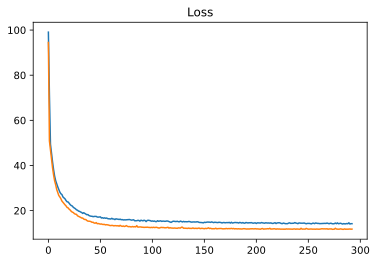

In [47]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [48]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [49]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.81%


### Первый прогон

TEST mape: 13.95%

### Второй прогон после EDA

TEST mape: 12.03%

### Третий прогон с модифицированной сетью

TEST mape: 11.98%

### Четвертый прогон сети с добавленным категориальным признаком статуса авто (новый, с пробегом и т.д.)

TEST mape: 11.89%

In [50]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

_____________

In [51]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

### Лемматизация

In [52]:
data['description'][0]

'Всем привет!\n\nПродам эксклюзивный проект 124 универсал 300TE-24 SportLine\n\nМодель 124.091 300 TE-24\nДвигатель 104.980\nТрансмиссия 722.359\nЦвет кузова 040 (черный)\nОтделка салона 271 (Кожа черная / "антрацит")\n\nОпции:\n211 Автоматическая блокировка дифференциала (ASD)\n240 Индикатор внешней температуры\n244 Спортивные сиденья спереди\n281 Спортивное рулевое колесо с отделкой из кожи (диаметр 390 мм) и кожаный рычаг КПП\n291 Подушка безопасности для водителя и переднего пассажира\n300 Дополнительный бардачок в вещевом отсеке спереди\n412 Люк с электроприводом и устройством подъёма\n420 Автоматическая коробка передач, напольное исполнение\n440 Темпомат (круиз-контроль)\n538 Автоматическая антенна\n541 Двойные занавески для багажного пространства и пасажирского отсека (сетка/шторка)\n570 Складной подлокотник спереди\n586 Кондиционер Behr и электрические стеклоподъемники передних и задних дверей\n598 Атермальные боковые и заднее стекла, заднее стекло с подогревом (ESG)\n650 Спорт

In [53]:

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [54]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Для обработки текста используем лемматизацию и стоп-слова. 

In [55]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

#Preprocess function
def stop_words(data):
    tokens = mystem.lemmatize(data.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    data = " ".join(tokens)
    
    return data

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [56]:
for index in data.index:
    data['description'][index] = stop_words(data['description'][index])
#     data['description'][index]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
data['description']

0       привет продавать эксклюзивный проект 124 униве...
1       продавать любимый тачил .. обвес тюнинг hamman...
2       машина продаваться первый перебирать двигатель...
3       автомобиль отличный состояние весь родной крас...
4       немка бесключивый доступ камера задний вид авт...
                              ...                        
8348    продаваться любимый автомобиль год эксплуатаци...
8349    купить официальный дилер 2017 г третий владеле...
8350    торг место весь работать сборка немецкий резин...
8351    автомобиль отличный состояние 3 авто семья обс...
8352    удлиненный заводской pullman база w140 вообще-...
Name: description, Length: 8353, dtype: object

In [62]:
len(data['description'][0])

2046

data.shape

(69982, 1104)

#### Каждое полученное слово "токенизируем". 

In [63]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [64]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]
print(text_train.shape, text_test.shape, text_sub.shape)

(5679,) (1003,) (1671,)


### Tokenizer

#### Для того, чтоб модель корректно воспринимала текст его необходимо токенизировать - конвертировать текст в векторное представление.

In [65]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.2 s, sys: 10 ms, total: 1.21 s
Wall time: 1.21 s


In [66]:
# tokenize.word_index

In [67]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape)

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 1.25 s


In [68]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

•  автомобиль проверять 110 пункт •  автокредит специальный ставка 13 7 ауди центр север официальный дилер audi входить группа компания рольф являться крупный дилер европа предлагать ряд услуга покупка продажа автомобиль пробег протяжение многий год наш дилерский центр являться лидер продажа автомобиль пробег среди весь дилер audi россия предоставлять клиент самый большой выбор автомобиль пробег audi марка каждый автомобиль проходить тщательный диагностика подготовка гарантировать находиться отличный состояние убеждаться правильный выбор возможность проходить тест-драйв  ―  ознакомительный поездка интересовать автомобиль смочь ознакомляться автомобиль выходить дом  –  наш менеджер проводить online презентация видеозвонок показывать выбирать автомобиль также ауди центр север представлять уникальный предложение кредитование автомобиль пробег индивидуальный условие специалист компания подбирать хороший условие кредитование 6 000 проверенный автомобиль пробег гарантия 2 год ждать сайт rolf

### RNN NLP

In [69]:
MAX_SEQUENCE_LENGTH

256

#### Изначально предложенная в Baseline модель была переделана, с учётом количества входных признаков (число нейронов) и с учетом общей архитектуры сети:

##### 1. Помимо LSTM ячеек пробовалось использование GRU, как наиболее производительных. Однако компромисс между произоводительностью и репрезнтативностью результата особо не дал. 

##### 2. Согласно теории применение прореживания в рекуррентных сетях между слоями может негативно отражаться на общем ходе обучения, поскольку для сохранения корректной последовательности в сети требуется "обнулять" одни и те же нейроны, применяя одну и ту же "маску". Чтоб этот процесс был корректнее и модель правильно распространяла ошибку - в Keras предусмотрен механизм прореживания на уровне слоёв LSTM или GRU. Dropout на уровне входа и recurrent_droput на уровне рекуррентной связи. Использование recurrent_dropout сильно замедляет обучение сети и существенного результата в данном случае не даёт.

In [74]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, dropout = 0.5, return_sequences=True))
model_nlp.add(L.LSTM(128,dropout = 0.5))
model_nlp.add(L.Dense(128, activation="relu"))

model_nlp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 256)          5757440   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256, 256)          525312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
Total params: 6,496,384
Trainable params: 6,496,384
Non-trainable params: 0
_________________________________________________________________


### MLP

#### В качестве модели MLP модель из предыдущего раздела. 

In [75]:
from tensorflow.keras import regularizers
model_mlp = Sequential()
model_mlp.add(L.Dense(382, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1_l2(l1=0.000000001,l2=0.000000001), activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(193, kernel_regularizer=regularizers.l1_l2(l1=0.000000001,l2=0.000000001), activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(128))
model_mlp.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 382)               73344     
_________________________________________________________________
dropout_2 (Dropout)          (None, 382)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 193)               73919     
_________________________________________________________________
dropout_3 (Dropout)          (None, 193)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               24832     
Total params: 172,095
Trainable params: 172,095
Non-trainable params: 0
_________________________________________________________________


### Multiple Inputs NN

#### Keras предусматривает функциональный API, который позволяет строить графоподобные нейронные сети, состоящие из частей, обрабатывающих разные последовательности. В данном варианте с помощью API будем строить модель включающую в себя рекуррентную сеть и сеть, состоящую из полносвязных слоёв для обработки табличных данных. Суммарный результат будет та же регрессия, соответственно финальная функция активации будет также линейная, поэтому не указываем её. 

In [76]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1)(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [77]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_5_input (InputLayer)      [(None, 191)]        0                                            
__________________________________________________________________________________________________
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 382)          73344       dense_5_input[0][0]              
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 256)     5757440     seq_description[0][0]            
_______________________________________________________________________________________

### Fit

In [78]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [79]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [80]:
text_test_sequences.shape

(1003, 256)

text_test_sequences.shape

(10247, 256)

In [81]:
text_train_sequences

array([[    0,     0,     0, ...,   608, 21008,  2875],
       [    0,     0,     0, ...,   846,    36,    69],
       [    0,     0,     0, ...,     2, 17645, 17646],
       ...,
       [    0,     0,     0, ...,  1593,    17,    47],
       [    0,     0,     0, ...,    46,    75,    13],
       [    0,     0,     0, ...,    15,   900,   238]], dtype=int32)

In [82]:
print(text_train_sequences.shape, X_train.shape, y_train.shape)

(5679, 256) (5679, 191) (5679,)


print(text_train_sequences.shape, X_train.shape, y_train.shape)

(58064, 256) (58064, 1100) (58064,)

In [83]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=256,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
23/23 [==============================] - 5s 203ms/step - loss: 91.6791 - MAPE: 91.6791 - val_loss: 55.8005 - val_MAPE: 55.8005
Epoch 2/500
23/23 [==============================] - 4s 170ms/step - loss: 51.0769 - MAPE: 51.0769 - val_loss: 42.5121 - val_MAPE: 42.5121
Epoch 3/500
23/23 [==============================] - 4s 172ms/step - loss: 39.2382 - MAPE: 39.2382 - val_loss: 33.4728 - val_MAPE: 33.4727
Epoch 4/500
23/23 [==============================] - 4s 170ms/step - loss: 32.3565 - MAPE: 32.3565 - val_loss: 27.9920 - val_MAPE: 27.9920
Epoch 5/500
23/23 [==============================] - 4s 178ms/step - loss: 28.4282 - MAPE: 28.4282 - val_loss: 24.6094 - val_MAPE: 24.6094
Epoch 6/500
23/23 [==============================] - 4s 171ms/step - loss: 25.9004 - MAPE: 25.9003 - val_loss: 23.1214 - val_MAPE: 23.1213
Epoch 7/500
23/23 [==============================] - 4s 171ms/step - loss: 24.2638 - MAPE: 24.2638 - val_loss: 21.1239 - val_MAPE: 21.1238
Epoch 8/500
23/23 [========

### Первый прогон

12/12 [==============================] - 5s 390ms/step - loss: 10.6723 - MAPE: 10.6723 - val_loss: 14.4951 - val_MAPE: 14.4951

Epoch 125/500
12/12 [==============================] - 5s 404ms/step - loss: 10.5826 - MAPE: 10.5826 - val_loss: 14.4087 - val_MAPE: 14.4087

Epoch 126/500
12/12 [==============================] - 5s 388ms/step - loss: 10.6843 - MAPE: 10.6843 - val_loss: 14.5542 - val_MAPE: 14.5542

Epoch 127/500
12/12 [==============================] - 5s 412ms/step - loss: 10.6472 - MAPE: 10.6472 - val_loss: 14.5484 - val_MAPE: 14.5484

Epoch 128/500
12/12 [==============================] - 5s 399ms/step - loss: 10.6584 - MAPE: 10.6584 - val_loss: 14.4466 - val_MAPE: 14.4466

Epoch 129/500
12/12 [==============================] - 5s 383ms/step - loss: 10.4253 - MAPE: 10.4253 - val_loss: 14.4688 - val_MAPE: 14.4688

Epoch 130/500
12/12 [==============================] - 5s 409ms/step - loss: 10.6899 - MAPE: 10.6899 - val_loss: 14.4716 - val_MAPE: 14.4716

Epoch 131/500
12/12 [==============================] - 5s 409ms/step - loss: 10.5103 - MAPE: 10.5103 - val_loss: 14.4613 - val_MAPE: 14.4613

### Второй прогон после EDA

Epoch 117/500
12/12 [==============================] - 4s 342ms/step - loss: 12.5432 - MAPE: 12.5432 - val_loss: 12.2873 - val_MAPE: 12.2873

Epoch 118/500
12/12 [==============================] - 4s 359ms/step - loss: 12.3871 - MAPE: 12.3871 - val_loss: 12.4253 - val_MAPE: 12.4253

Epoch 119/500
12/12 [==============================] - 5s 380ms/step - loss: 12.4203 - MAPE: 12.4203 - val_loss: 12.3988 - val_MAPE: 12.3988

Epoch 120/500
12/12 [==============================] - 4s 347ms/step - loss: 12.3576 - MAPE: 12.3576 - val_loss: 12.5306 - val_MAPE: 12.5306

Epoch 121/500
12/12 [==============================] - 4s 355ms/step - loss: 12.3864 - MAPE: 12.3864 - val_loss: 12.3972 - val_MAPE: 12.3972

Epoch 122/500
12/12 [==============================] - 4s 346ms/step - loss: 12.3605 - MAPE: 12.3605 - val_loss: 12.3689 - val_MAPE: 12.3689

Epoch 123/500
12/12 [==============================] - 4s 358ms/step - loss: 12.3342 - MAPE: 12.3342 - val_loss: 12.3555 - val_MAPE: 12.3555

### Третий прогон с лемматизацией и стоп-словами

12/12 [==============================] - 3s 250ms/step - loss: 12.6042 - MAPE: 12.6042 - val_loss: 12.2241 - val_MAPE: 12.2241

Epoch 117/500
12/12 [==============================] - 3s 261ms/step - loss: 12.4054 - MAPE: 12.4054 - val_loss: 12.3450 - val_MAPE: 12.3450

Epoch 118/500
12/12 [==============================] - 3s 254ms/step - loss: 12.4255 - MAPE: 12.4255 - val_loss: 12.2521 - val_MAPE: 12.2521

Epoch 119/500
12/12 [==============================] - 3s 247ms/step - loss: 12.3796 - MAPE: 12.3796 - val_loss: 12.6123 - val_MAPE: 12.6123

Epoch 120/500
12/12 [==============================] - 3s 244ms/step - loss: 12.5134 - MAPE: 12.5134 - val_loss: 12.2685 - val_MAPE: 12.2685

Epoch 121/500
12/12 [==============================] - 3s 266ms/step - loss: 12.3433 - MAPE: 12.3433 - val_loss: 12.4576 - val_MAPE: 12.4576

Epoch 122/500
12/12 [==============================] - 3s 250ms/step - loss: 12.4494 - MAPE: 12.4494 - val_loss: 12.3573 - val_MAPE: 12.3573

Epoch 123/500
12/12 [==============================] - 3s 245ms/step - loss: 12.4216 - MAPE: 12.4216 - val_loss: 12.4154 - val_MAPE: 12.4154

Epoch 124/500
12/12 [==============================] - 3s 251ms/step - loss: 12.2567 - MAPE: 12.2567 - val_loss: 12.2637 - val_MAPE: 12.2637

Epoch 125/500
12/12 [==============================] - 3s 257ms/step - loss: 12.3520 - MAPE: 12.3520 - val_loss: 12.3557 - val_MAPE: 12.3557

### Четвёртый прогон сети

Epoch 73/500
23/23 [==============================] - 68s 3s/step - loss: 12.0429 - MAPE: 12.0428 - val_loss: 12.4760 - val_MAPE: 12.4759

Epoch 74/500
23/23 [==============================] - 68s 3s/step - loss: 12.2098 - MAPE: 12.2097 - val_loss: 12.7509 - val_MAPE: 12.7508

Epoch 75/500
23/23 [==============================] - 68s 3s/step - loss: 12.1448 - MAPE: 12.1447 - val_loss: 12.2070 - val_MAPE: 12.2068

Epoch 76/500
23/23 [==============================] - 68s 3s/step - loss: 12.0131 - MAPE: 12.0130 - val_loss: 12.0351 - val_MAPE: 12.0350

Epoch 77/500
23/23 [==============================] - 67s 3s/step - loss: 11.7788 - MAPE: 11.7787 - val_loss: 12.8926 - val_MAPE: 12.8925

Epoch 78/500
23/23 [==============================] - 68s 3s/step - loss: 12.2372 - MAPE: 12.2370 - val_loss: 12.1263 - val_MAPE: 12.1262

Epoch 79/500
23/23 [==============================] - 68s 3s/step - loss: 12.0148 - MAPE: 12.0147 - val_loss: 12.1353 - val_MAPE: 12.1352



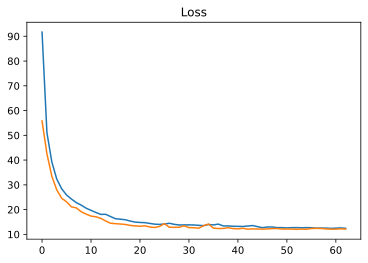

In [84]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [85]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [86]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.15%


### Первый прогон

TEST mape: 14.46%

### Второй прогон после EDA

TEST mape: 12.36%

### Третий прогон с лемматизацией и стоп-словами

TEST mape: 12.36%

### Четвертый прогон с новым признаком status и иной архитектурой сети

TEST mape: 12.15%

In [87]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# Model 5: Добавляем картинки

#### Для  формирования финальной, общей модели, будем использовать тот же функциональный API Keras. В этот раз, кроме рекуррентной и MLP, будет добавлена сверточная сеть, для обработки изображений.

### Data

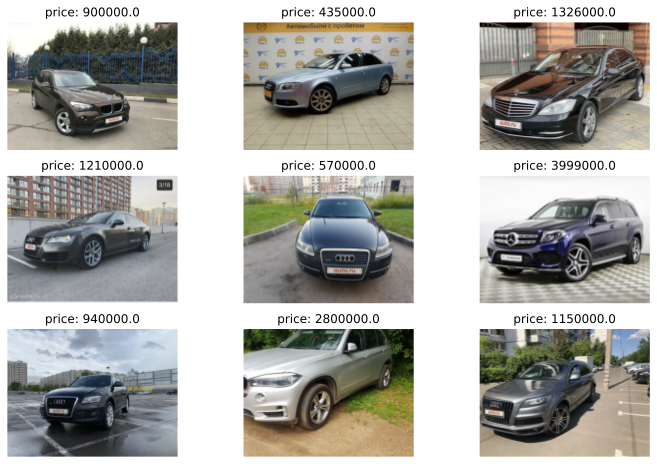

In [88]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [89]:
size = (240, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 240, 3) dtype uint8
images shape (1003, 240, 240, 3) dtype uint8
images shape (1671, 240, 240, 3) dtype uint8


### albumentations

In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [92]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [93]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 240 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

#### Аугментацию из Baseline заменим на используемую ранее в заданиях по прогнозу стоимости автомобилей albumentations

In [94]:
augmentation = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = augmentation,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

In [95]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [96]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [97]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

#### В качестве базовой модели для распознавания образов будеи использовать EfficientNetB3. На самом деле это далеко не единственный вариант, который стоило бы проверить.

In [98]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [99]:
from tensorflow.keras import regularizers
tabular_model = Sequential()
tabular_model.add(L.Dense(382, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1_l2(l1=0.000000001,l2=0.000000001), activation="relu"))
tabular_model.add(L.Dropout(0.5))
tabular_model.add(L.Dense(128, kernel_regularizer=regularizers.l1_l2(l1=0.000000001,l2=0.000000001), activation="relu"))
tabular_model.add(L.Dropout(0.5))

tabular_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 382)               73344     
_________________________________________________________________
dropout_4 (Dropout)          (None, 382)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               49024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
Total params: 122,368
Trainable params: 122,368
Non-trainable params: 0
_________________________________________________________________


In [100]:
nlp_model = Sequential()
nlp_model.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
nlp_model.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
nlp_model.add(L.LSTM(256, dropout = 0.5, return_sequences=True))
nlp_model.add(L.LSTM(128,dropout = 0.5))
nlp_model.add(L.Dense(128, activation="relu"))
# model_nlp.add(L.Dropout(0.25))
nlp_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 256, 256)          5757440   
_________________________________________________________________
lstm_4 (LSTM)                (None, 256, 256)          525312    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
Total params: 6,496,384
Trainable params: 6,496,384
Non-trainable params: 0
_________________________________________________________________


#### Финально объединяем выходы сетей и получаем достаточно объёмную сеть на 17,631,920 параметров

#### Обучение, как и в прошлых разделах, проводим с checkpoint и earlystop, для фиксации наилучшего результата и остановки процесса обучения, если улучшения не происходит

In [102]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(128, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 240, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 240, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 241, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [103]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [104]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [105]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 101s 533ms/step - loss: 59.9437 - MAPE: 59.9436 - val_loss: 37.7583 - val_MAPE: 37.7582
Epoch 2/100
190/190 [==============================] - 99s 521ms/step - loss: 33.4887 - MAPE: 33.4887 - val_loss: 69.7586 - val_MAPE: 69.7585
Epoch 3/100
190/190 [==============================] - 99s 522ms/step - loss: 27.6307 - MAPE: 27.6306 - val_loss: 23.8703 - val_MAPE: 23.8702
Epoch 4/100
190/190 [==============================] - 100s 524ms/step - loss: 24.5580 - MAPE: 24.5580 - val_loss: 21.3912 - val_MAPE: 21.3911
Epoch 5/100
190/190 [==============================] - 99s 519ms/step - loss: 22.4419 - MAPE: 22.4418 - val_loss: 19.7652 - val_MAPE: 19.7651
Epoch 6/100
190/190 [==============================] - 99s 523ms/step - loss: 20.5631 - MAPE: 20.5630 - val_loss: 18.5876 - val_MAPE: 18.5876
Epoch 7/100
190/190 [==============================] - 99s 523ms/step - loss: 18.9005 - MAPE: 18.9004 - val_loss: 17.3968 - val_MAPE: 17.3967
Epoc

### Первый прогон


Epoch 37/100
190/190 [==============================] - 152s 801ms/step - loss: 10.8001 - MAPE: 10.8001 - val_loss: 14.1561 - val_MAPE: 14.1561

Epoch 38/100
190/190 [==============================] - 154s 809ms/step - loss: 10.8057 - MAPE: 10.8057 - val_loss: 14.2506 - val_MAPE: 14.2506

Epoch 39/100
190/190 [==============================] - 153s 806ms/step - loss: 10.5663 - MAPE: 10.5663 - val_loss: 14.3146 - val_MAPE: 14.3146

Epoch 40/100
190/190 [==============================] - 155s 815ms/step - loss: 10.5327 - MAPE: 10.5327 - val_loss: 14.0886 - val_MAPE: 14.0886

Epoch 41/100
190/190 [==============================] - 152s 798ms/step - loss: 10.6754 - MAPE: 10.6754 - val_loss: 14.2720 - val_MAPE: 14.2720

### Второй прогон

Epoch 42/100
190/190 [==============================] - 98s 515ms/step - loss: 13.3797 - MAPE: 13.3796 - val_loss: 12.5749 - val_MAPE: 12.5748

Epoch 43/100
190/190 [==============================] - 99s 519ms/step - loss: 13.3294 - MAPE: 13.3292 - val_loss: 12.6409 - val_MAPE: 12.6407

Epoch 44/100
190/190 [==============================] - 98s 513ms/step - loss: 13.3279 - MAPE: 13.3277 - val_loss: 12.0178 - val_MAPE: 12.0177

Epoch 45/100
190/190 [==============================] - 98s 517ms/step - loss: 13.2041 - MAPE: 13.2040 - val_loss: 12.0573 - val_MAPE: 12.0572

Epoch 46/100
190/190 [==============================] - 98s 517ms/step - loss: 13.0808 - MAPE: 13.0807 - val_loss: 12.3638 - val_MAPE: 12.3636

Epoch 47/100
190/190 [==============================] - 98s 517ms/step - loss: 13.3053 - MAPE: 13.3052 - val_loss: 12.1939 - val_MAPE: 12.1937

Epoch 48/100
190/190 [==============================] - 98s 518ms/step - loss: 13.1022 - MAPE: 13.1020 - val_loss: 12.0418 - val_MAPE: 12.0416


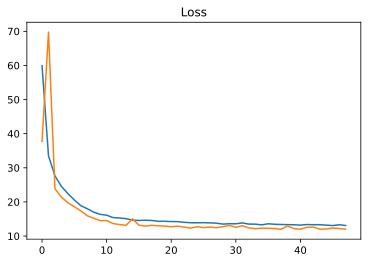

In [106]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [107]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [108]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.04%


### Первый прогон

TEST mape: 14.27%

### Второй прогон с аугментацией

TEST mape: 12.04%

In [109]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

In [111]:
from IPython.display import FileLink
FileLink('nn3_submission.csv')

/kaggle/working/nn3_submission.csv

# Blend

In [112]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.37%


In [113]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [121]:
model_mlp = Sequential()
model_mlp.add(L.Dense(382, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1_l2(l1=0.000000001,l2=0.000000001), activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(193, kernel_regularizer=regularizers.l1_l2(l1=0.000000001,l2=0.000000001), activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(1))

In [122]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [123]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [124]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_19_input (InputLayer)     [(None, 191)]        0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 382)          73344       dense_19_input[0][0]             
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 382)          0           dense_19[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 193)          73919       dropout_8[0][0]                  
_______________________________________________________________________________________

### Первый прогон

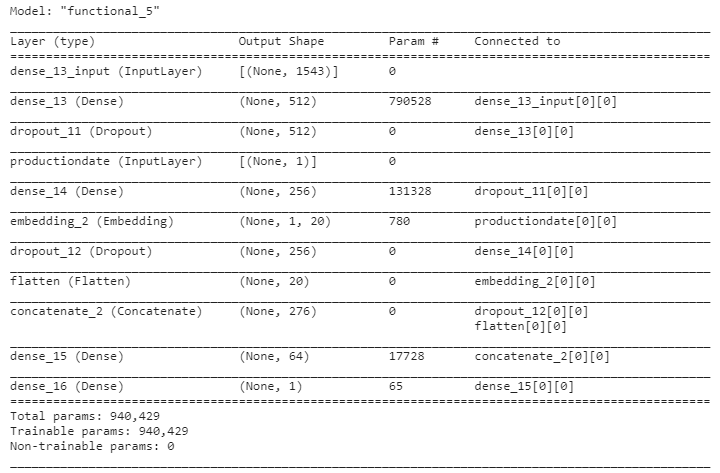

In [125]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [126]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 20ms/step - loss: 99.9993 - MAPE: 99.9993 - val_loss: 99.9910 - val_MAPE: 99.9910
Epoch 2/500
12/12 [==============================] - 0s 8ms/step - loss: 99.8880 - MAPE: 99.8880 - val_loss: 99.3837 - val_MAPE: 99.3837
Epoch 3/500
12/12 [==============================] - 0s 8ms/step - loss: 97.3941 - MAPE: 97.3940 - val_loss: 90.7477 - val_MAPE: 90.7477
Epoch 4/500
12/12 [==============================] - 0s 8ms/step - loss: 75.3961 - MAPE: 75.3961 - val_loss: 51.6158 - val_MAPE: 51.6158
Epoch 5/500
12/12 [==============================] - 0s 8ms/step - loss: 53.9601 - MAPE: 53.9600 - val_loss: 49.5333 - val_MAPE: 49.5332
Epoch 6/500
12/12 [==============================] - 0s 8ms/step - loss: 49.7415 - MAPE: 49.7414 - val_loss: 47.2798 - val_MAPE: 47.2797
Epoch 7/500
12/12 [==============================] - 0s 8ms/step - loss: 46.5602 - MAPE: 46.5601 - val_loss: 44.6077 - val_MAPE: 44.6076
Epoch 8/500
12/12 [=====================

### Прогон первый раз


Epoch 61/500
12/12 [==============================] - 0s 13ms/step - loss: 13.6289 - MAPE: 13.6289 - val_loss: 15.4412 - val_MAPE: 15.4412

Epoch 62/500
12/12 [==============================] - 0s 14ms/step - loss: 13.7593 - MAPE: 13.7593 - val_loss: 15.4537 - val_MAPE: 15.4537

Epoch 63/500
12/12 [==============================] - 0s 13ms/step - loss: 13.4702 - MAPE: 13.4702 - val_loss: 15.5949 - val_MAPE: 15.5949

Epoch 64/500
12/12 [==============================] - 0s 13ms/step - loss: 13.7326 - MAPE: 13.7326 - val_loss: 15.5078 - val_MAPE: 15.5078

Epoch 65/500
12/12 [==============================] - 0s 14ms/step - loss: 13.5932 - MAPE: 13.5932 - val_loss: 15.4794 - val_MAPE: 15.4794

Epoch 66/500
12/12 [==============================] - 0s 13ms/step - loss: 13.4312 - MAPE: 13.4312 - val_loss: 15.5564 - val_MAPE: 15.5564

Epoch 67/500
12/12 [==============================] - 0s 14ms/step - loss: 13.4350 - MAPE: 13.4350 - val_loss: 15.5991 - val_MAPE: 15.5991

Epoch 68/500
12/12 [==============================] - 1s 94ms/step - loss: 13.3841 - MAPE: 13.3841 - val_loss: 15.6996 - val_MAPE: 15.6996

Epoch 69/500
12/12 [==============================] - 0s 25ms/step - loss: 13.4171 - MAPE: 13.4171 - val_loss: 15.5706 - val_MAPE: 15.5706

Epoch 70/500
12/12 [==============================] - 0s 14ms/step - loss: 13.4331 - MAPE: 13.4331 - val_loss: 15.5566 - val_MAPE: 15.5566

### Второй прогон сети



Epoch 140/500
12/12 [==============================] - 0s 22ms/step - loss: 14.2899 - MAPE: 14.2897 - val_loss: 12.1483 - val_MAPE: 12.1481

Epoch 141/500
12/12 [==============================] - 0s 8ms/step - loss: 14.0843 - MAPE: 14.0840 - val_loss: 11.9735 - val_MAPE: 11.9733

Epoch 142/500
12/12 [==============================] - 0s 8ms/step - loss: 14.2477 - MAPE: 14.2475 - val_loss: 12.3645 - val_MAPE: 12.3642

Epoch 143/500
12/12 [==============================] - 0s 8ms/step - loss: 14.2301 - MAPE: 14.2299 - val_loss: 12.1159 - val_MAPE: 12.1157

Epoch 144/500
12/12 [==============================] - 0s 8ms/step - loss: 14.2992 - MAPE: 14.2990 - val_loss: 12.0783 - val_MAPE: 12.0780

In [127]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 12.08%


### Прогон первый раз

TEST mape: 15.56%

### Второй прогон после аугментации и модифицированной архитектуры

TEST mape: 12.08%

# Заключение


Совокупно модели дали неплохой результат. Улучшать его, меняя только лишь архитектуры сетей, не совсем верный подход, на мой взгляд. Первостепенно, всё же, разнообразие признаков. Так как в процессе обучения присутвует обработка изображений, предложенных соревнованием, соответственно присутвует ограничение, связанное с sell_id, так как имена файлов изображений содержат как раз тот самый sell_id. Попытка обогатить датасет с помощью парсинга уперлась в невозможность объединения сетей, так как разное количество признаков на входе выдаёт ошибку. Возможно тут сказывается нехватка опыта. Генерация новых признаков возможна, но если использовать только лишь предложенные, то генерация одних вынуждает, естественно, удалять другие, чтоб избежать сильных зависимостей между ними. Потенциально можно было бы попробовать:

1. Добавить новые признаки, такие, например, как расход топлива для каждой модели отдельно
2. При достаточном разнообразии марок машин можно было бы использовать рейтинги продаж
3. Информацию о надежности можно было бы использовать в качестве категориального признака.
4. Оценки сайтов, таких, как дром.ру, были бы весьма кстати.
5. И т.д., по фантазии

По улучшению сетей:

1. Попробовать ещё больше разных архитектур
2. Для сверточной сети попробовать FineTuning
3. Попробовать разные основные модели свёрточной сети
4. Попробовать обучение с разными гипперпараметрами. 

Все манипуляции непосредственно с нейросетями, особенно с теми, которые объединяют в себе разные выходы, занимают много времени, конечно. 

Как вариант, при дальнейшем изучении вопроса, я бы двигался в направлении снижения ёмкости сети, для улучшения производительности, и больше бы внимания уделил разделу подготовки данных, что, наверно, всё таки основа всего процесса.


